# Plotting

``tabensemb.trainer.Trainer`` provides some useful plotting methods to analyse the dataset or results.

In [1]:
import torch
from tabensemb.trainer import Trainer
from tabensemb.model import *
from tabensemb.config import UserConfig
import tabensemb
import os
from tempfile import TemporaryDirectory

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

temp_path = TemporaryDirectory()
tabensemb.setting["default_output_path"] = os.path.join(temp_path.name, "output")
tabensemb.setting["default_config_path"] = os.path.join(temp_path.name, "configs")
tabensemb.setting["default_data_path"] = os.path.join(temp_path.name, "data")

trainer = Trainer(device=device)
mpg_columns = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year",
    "origin",
    "car_name",
]
cfg = UserConfig.from_uci("Auto MPG", column_names=mpg_columns, sep=r"\s+")
trainer.load_config(cfg)
trainer.load_data()
models = [
    PytorchTabular(trainer, model_subset=["Category Embedding"]),
    CatEmbed(trainer, model_subset=["Category Embedding"])
]
trainer.add_modelbases(models)
trainer.train(stderr_to_stdout=True)

Using cuda device
cylinders is Integer and will be treated as a continuous feature.
model_year is Integer and will be treated as a continuous feature.
origin is Integer and will be treated as a continuous feature.
Unknown values are detected in ['horsepower']. They will be treated as np.nan.
The project will be saved to /tmp/tmp2ahan3y9/output/auto-mpg/2023-09-23-18-44-37-0_UserInputConfig
Dataset size: 238 80 80
Data saved to /tmp/tmp2ahan3y9/output/auto-mpg/2023-09-23-18-44-37-0_UserInputConfig (data.csv and tabular_data.csv).

-------------Run PytorchTabular-------------

Training Category Embedding
Global seed set to 42
2023-09-23 18:44:38,295 - {pytorch_tabular.tabular_model:473} - INFO - Preparing the DataLoaders
2023-09-23 18:44:38,296 - {pytorch_tabular.tabular_datamodule:290} - INFO - Setting up the datamodule for regression task
2023-09-23 18:44:38,303 - {pytorch_tabular.tabular_model:521} - INFO - Preparing the Model: CategoryEmbeddingModel
2023-09-23 18:44:38,314 - {pytorch

If LaTeX is detected, `matplotlib.rc("text", usetex=True)` is called to use LaTeX for a better text appearance. However, if there exist `"_"` in feature names, LaTeX will throw errors. Here we reset defaults of `matplotlib.rcParams` to disable LaTeX.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams["figure.autolayout"] = True

`Trainer.plot_feature_box` will show the box plot of features.

**Remark**: All methods introduced in this part pass arguments, such as `figure_kwargs`, `bar_kwargs`, `pairplot_kwargs`, etc., to corresponding functions for limited but sufficient customization. See the API docs for their meanings.

**Remark**: Colors can be globally controlled by replacing `tabensemb.utils.global_palette`. For some methods, `clr` can be given to control colors. One can also pass kwargs to arguments like `bar_kwargs` to over-ride default behaviors including colors.

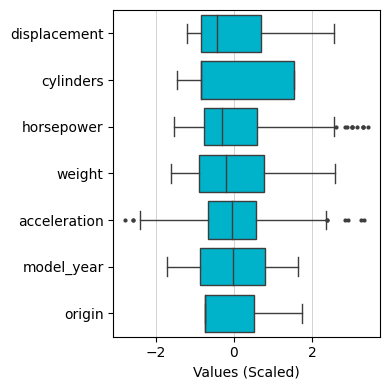

<Axes: xlabel='Values (Scaled)'>

In [3]:
trainer.plot_feature_box(imputed=True, figure_kwargs=dict(figsize=(4, 4)))

`Trainer.plot_pairplot` will show correlations between each two features. It uses `seaborn.pairplot` to achieve this, so the plot can be customized by passing the `pairplot_kwargs` argument. See [the documentation](https://seaborn.pydata.org/generated/seaborn.pairplot.html) for possible arguments.

/home/xlluo/anaconda3/envs/tabular_ensemble/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/xlluo/hdd/tabular_ensemble/tabensemb/trainer/trainer.py:3697: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


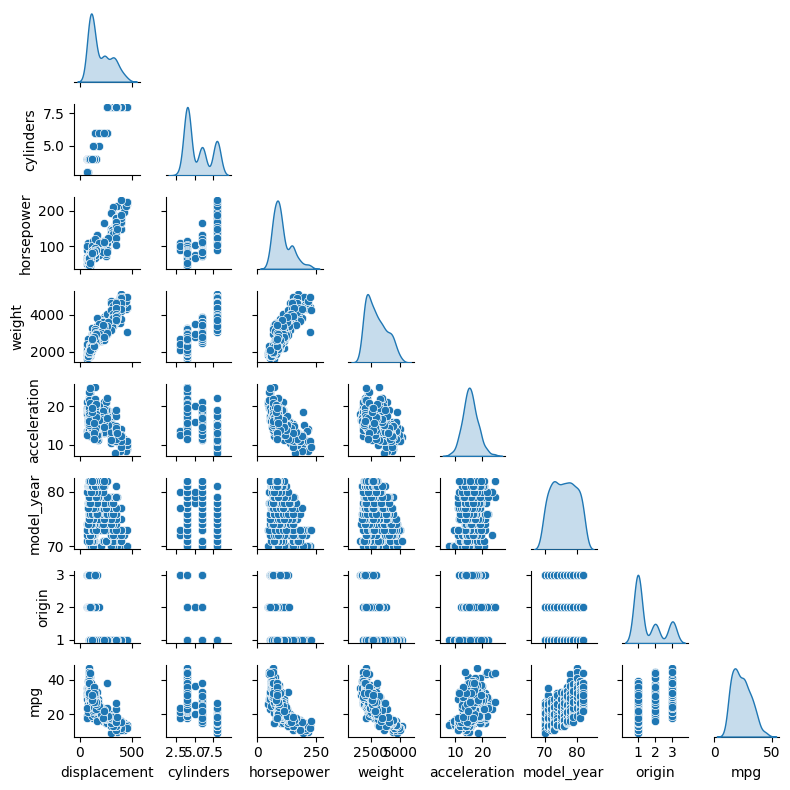

In [4]:
trainer.plot_pairplot(pairplot_kwargs=dict(height=1))

`Trainer.plot_corr` will show the Pearson correlation coefficients between each two features.

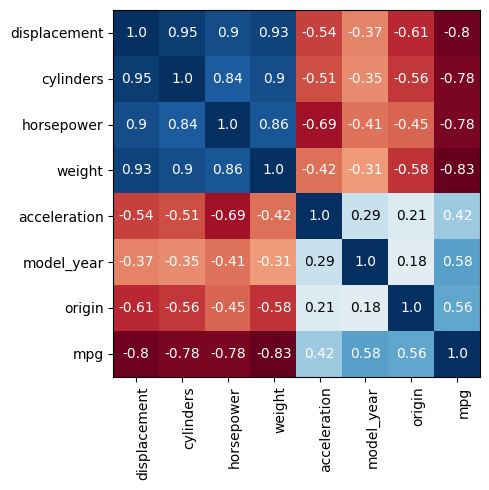

<Axes: >

In [5]:
trainer.plot_corr(imputed=True, figure_kwargs=dict(figsize=(5, 5)), imshow_kwargs=dict(cmap="RdBu"))

`Trainer.plot_corr_with_label` focuses on the correlation between the target and each feature.

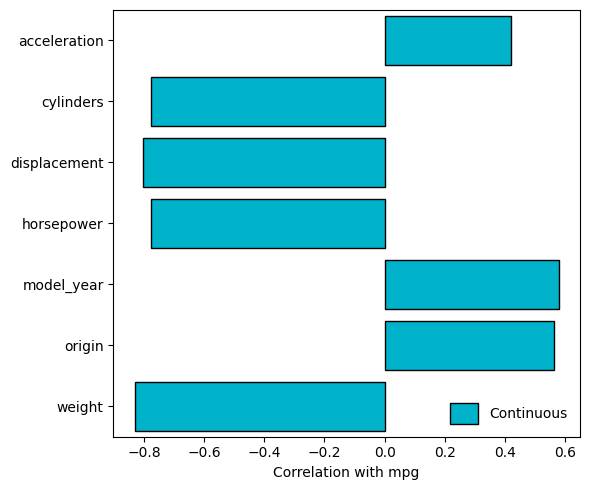

<Axes: xlabel='Correlation with mpg'>

In [6]:
trainer.plot_corr_with_label(imputed=True, figure_kwargs={"figsize": (6, 5)})

`Trainer.plot_hist` shows the histogram for each feature. If the argument `category` is given, histograms of each unique value of the `category` column will be plotted separately and stacked together.

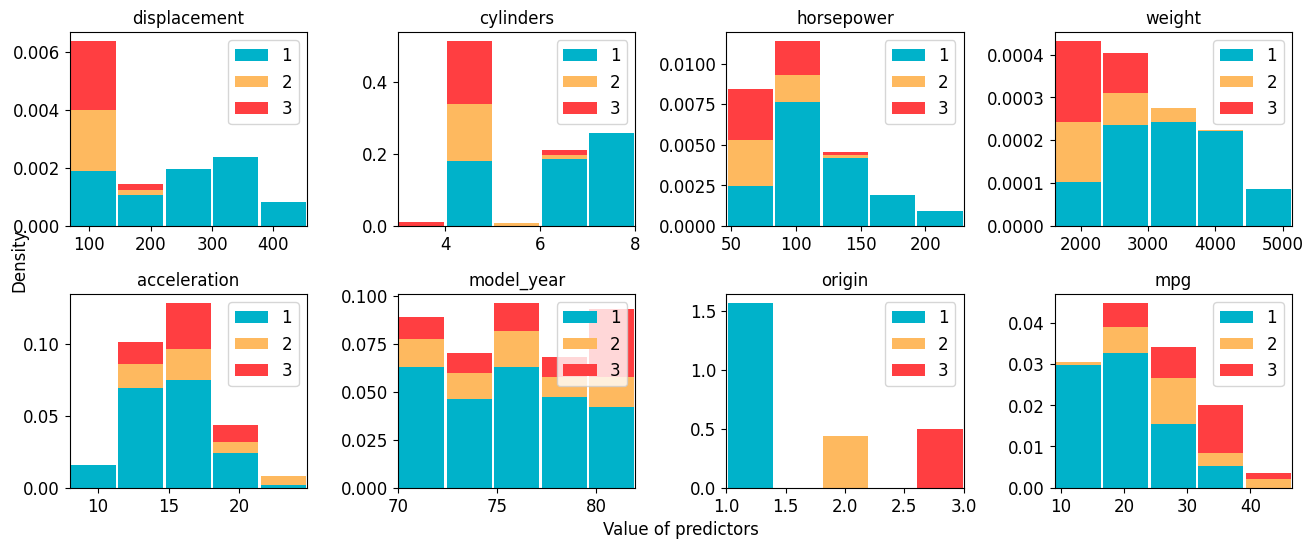

In [7]:
_ = trainer.plot_hist_all(imputed=False, hist_kwargs={"bins": 5}, category="origin", legend_kwargs={"loc": "upper right"})

`Trainer.plot_truth_pred` will show the comparison between ground truth values and predictions.

Training MSE Loss: 11.2517, R2: 0.8254
Validation MSE Loss: 12.3672, R2: 0.7791
Testing MSE Loss: 7.8380, R2: 0.8542


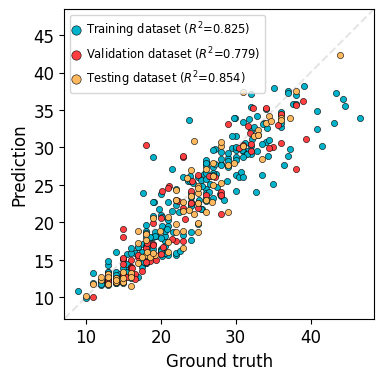

<Axes: xlabel='Ground truth', ylabel='Prediction'>

In [8]:
trainer.plot_truth_pred(program="PytorchTabular", model_name="Category Embedding", log_trans=False, legend_kwargs=dict(fontsize="x-small"), figure_kwargs=dict(figsize=(4, 4)))

`Trainer.plot_feature_importance` calculates and plots feature importance. Two methods are supported to calculate feature importance: `permutation` and `shap`. [Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature.) is the decrease of the metric when permuting (shuffling) the feature. [SHAP](https://github.com/shap/shap) is a game theory approach. They might get different results.

For `pytorch` based models, we use `captum` ([link](https://captum.ai/docs/introduction)) and `shap.DeepExplainer` ([link](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)) for faster calculations.

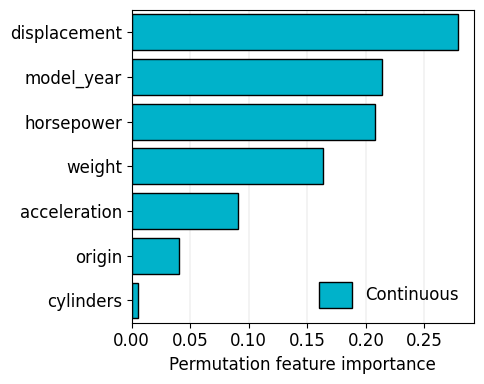

<Axes: xlabel='Permutation feature importance'>

In [9]:
trainer.plot_feature_importance(program="PytorchTabular", model_name="Category Embedding", figure_kwargs=dict(figsize=(5, 4)))

Feature importance less than 1e-5: ['Unscaled-0', 'Unscaled-1', 'Unscaled-2', 'Unscaled-3', 'Unscaled-4', 'Unscaled-5', 'Unscaled-6']


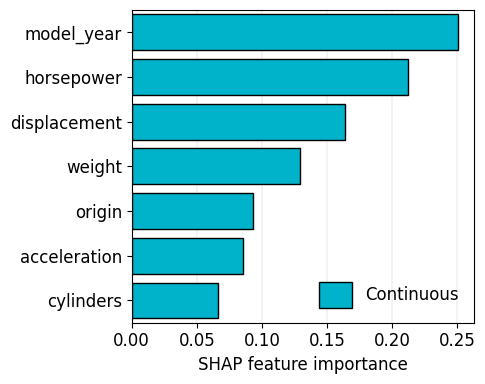

In [10]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    trainer.plot_feature_importance(program="CatEmbed", model_name="Category Embedding", method="shap", figure_kwargs=dict(figsize=(5, 4)))

`Trainer.plot_partial_dependence` uses bootstrap sampling to resample the dataset, fits the model on the resampled dataset, and obtains sequential predictions when assigning sequential values to a feature, to see the dependency of predictions on a feature.

Calculate PDP:  displacement
Calculate PDP:  cylinders
Calculate PDP:  horsepower
Calculate PDP:  weight
Calculate PDP:  acceleration
Calculate PDP:  model_year
Calculate PDP:  origin


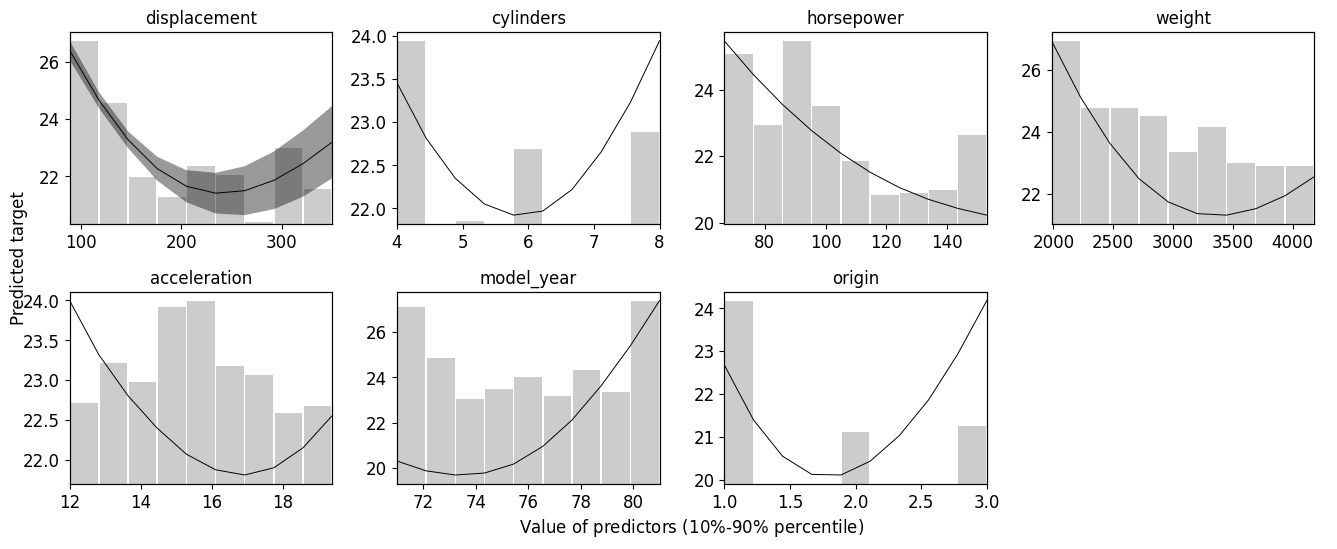

In [11]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    trainer.plot_partial_dependence_all(program="PytorchTabular", model_name="Category Embedding", n_bootstrap=3, grid_size=10, log_trans=False, upper_lim=9, lower_lim=2, CI=0.95)

`Trainer.plot_err_hist` shows the distribution of errors. If the argument `category` is given, one can try to analyse the relationship between categories and errors.

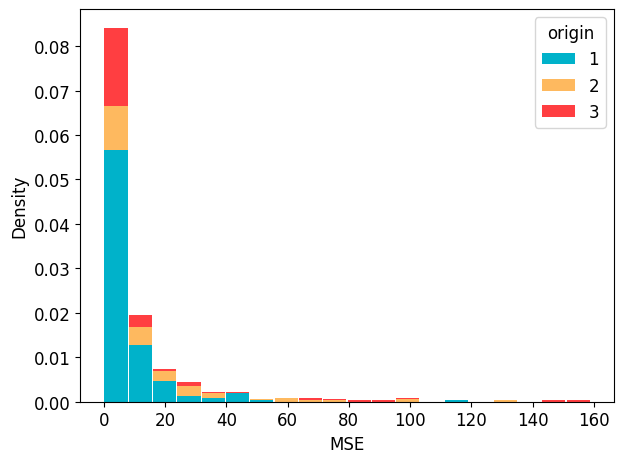

<Axes: xlabel='MSE', ylabel='Density'>

In [12]:
trainer.plot_err_hist(program="PytorchTabular", model_name="Category Embedding", metric="mse", category="origin", legend_kwargs={"title": "origin"})

`Trainer.plot_partial_err` shows the distribution of absolute error with respect to feature values. If the density of high error predictions is high in a certain range of a certain feature, data augmentation or additional experiments might be required.

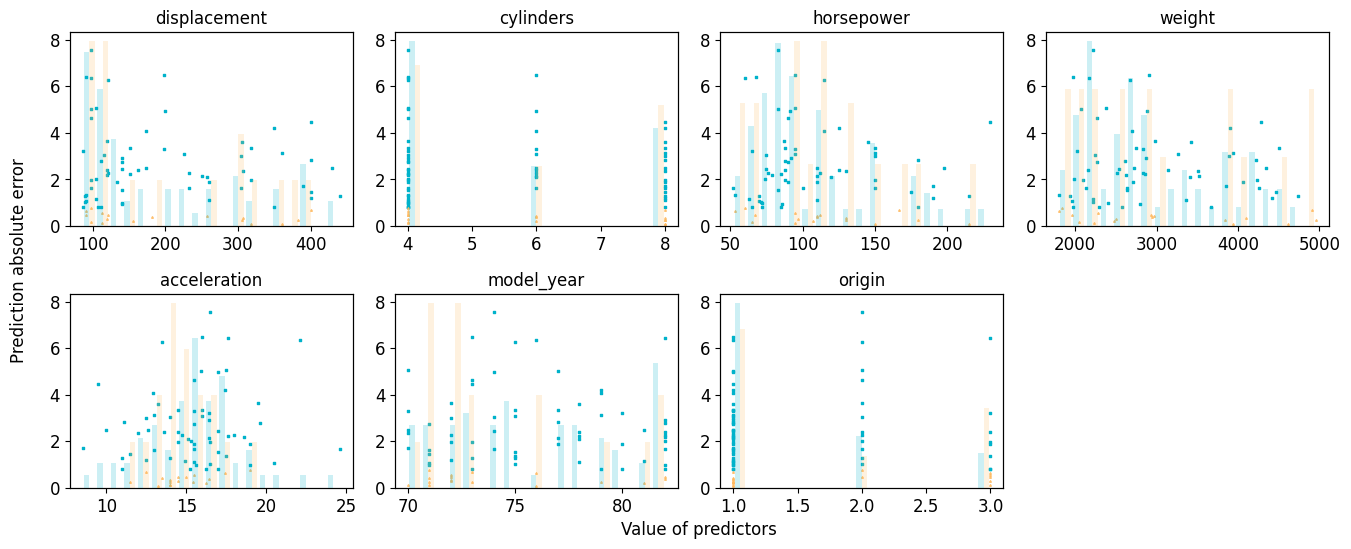

In [13]:
_ = trainer.plot_partial_err_all(program="PytorchTabular", model_name="Category Embedding")

`Trainer.plot_scatter` offers the utility to plot one feature versus the other. Here is an example that plots scatters between `weight` and `horsepower` whose `model_year` is in the range $[70, 74]$.

**Remark**: `select_by_value_kwargs` is the argument of `DataModule.select_by_value` which returns indices of datapoints that have specified values in the specified columns.

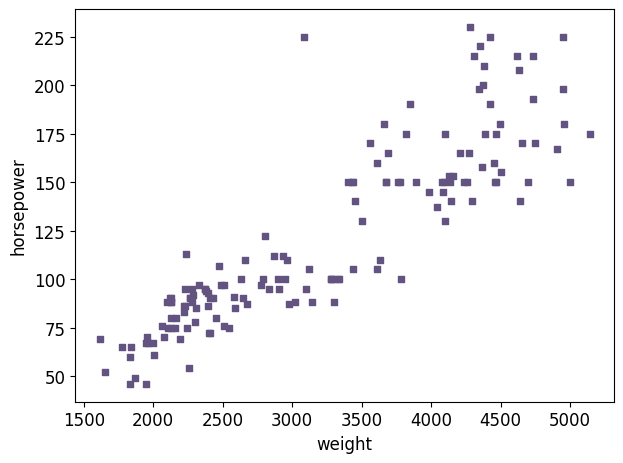

<Axes: xlabel='weight', ylabel='horsepower'>

In [14]:
trainer.plot_scatter(x_col="weight", y_col="horsepower", scatter_kwargs={"color": "#635380", "s": 15, "marker": "s"}, select_by_value_kwargs={"selection": {"model_year": (70, 74)}})

`Trainer.plot_on_one_axes` can plot multiple items (like scatters) on one `matplotlib.axes.Axes` instance. Here is an example that calls `Trainer.plot_scatter` twice to plots a group of scatters whose `model_year` is in the range $[70, 74]$ and the other group of scatters whose `model_year` is in the range $[75, 80]$.

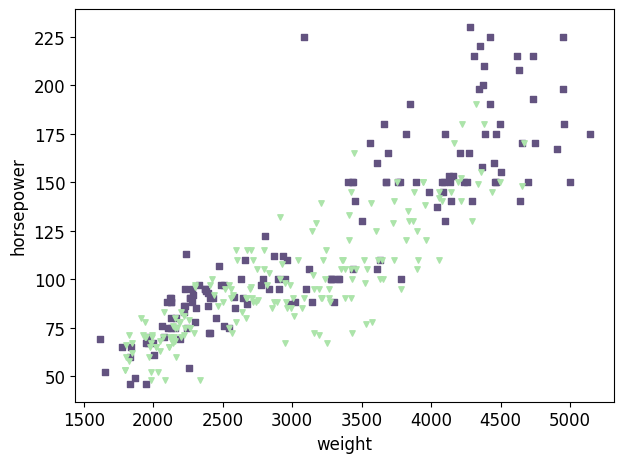

<Axes: xlabel='weight', ylabel='horsepower'>

In [15]:
trainer.plot_on_one_axes(
    meth_name="plot_scatter",
    meth_kwargs_ls=[
        dict(scatter_kwargs={"color": "#635380", "s": 15, "marker": "s", "label": "[70, 74]"}, select_by_value_kwargs={"selection": {"model_year": (70, 74)}}),
        dict(scatter_kwargs={"color": "#ACE4AA", "s": 15, "marker": "v", "label": "[75, 80]"}, select_by_value_kwargs={"selection": {"model_year": (75, 80)}})
    ],
    meth_fix_kwargs=dict(
        x_col="weight",
        y_col="horsepower",
        imputed=False,
    ),
    xlabel="weight",
    ylabel="horsepower",
)